In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


# Data import

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Actual Generation per Production Type_201601010000-201701010000.csv to Actual Generation per Production Type_201601010000-201701010000 (1).csv
Saving Actual Generation per Production Type_201701010000-201801010000.csv to Actual Generation per Production Type_201701010000-201801010000 (1).csv
Saving Actual Generation per Production Type_201801010000-201901010000.csv to Actual Generation per Production Type_201801010000-201901010000 (1).csv
Saving Actual Generation per Production Type_201901010000-202001010000.csv to Actual Generation per Production Type_201901010000-202001010000 (1).csv
Saving Actual Generation per Production Type_202001010000-202101010000.csv to Actual Generation per Production Type_202001010000-202101010000 (1).csv
Saving Actual Generation per Production Type_202101010000-202201010000.csv to Actual Generation per Production Type_202101010000-202201010000 (1).csv


In [ ]:
import io
df2016 = pd.read_csv(io.BytesIO(uploaded['Actual Generation per Production Type_201601010000-201701010000.csv']))
df2017 = pd.read_csv(io.BytesIO(uploaded['Actual Generation per Production Type_201701010000-201801010000.csv']))
df2018 = pd.read_csv(io.BytesIO(uploaded['Actual Generation per Production Type_201801010000-201901010000.csv']))
df2019 = pd.read_csv(io.BytesIO(uploaded['Actual Generation per Production Type_201901010000-202001010000.csv']))
df2020 = pd.read_csv(io.BytesIO(uploaded['Actual Generation per Production Type_202001010000-202101010000.csv']))
df2021 = pd.read_csv(io.BytesIO(uploaded['Actual Generation per Production Type_202101010000-202201010000.csv']))

# data.head()

# Data Preparation

In [ ]:
# Check missing values and data size
for i in [df2016,df2017,df2018,df2019,df2020,df2021]:
    print(i.isnull().sum())
    print('Data size:',i.shape)
    print('-----------------')

Area                                                            0
MTU                                                             0
Biomass  - Actual Aggregated [MW]                               2
Fossil Brown coal/Lignite  - Actual Aggregated [MW]             1
Fossil Coal-derived gas  - Actual Aggregated [MW]               1
Fossil Gas  - Actual Aggregated [MW]                            1
Fossil Hard coal  - Actual Aggregated [MW]                      1
Fossil Oil  - Actual Aggregated [MW]                            2
Fossil Oil shale  - Actual Aggregated [MW]                      1
Fossil Peat  - Actual Aggregated [MW]                           1
Geothermal  - Actual Aggregated [MW]                            2
Hydro Pumped Storage  - Actual Aggregated [MW]               8784
Hydro Pumped Storage  - Actual Consumption [MW]                 2
Hydro Run-of-river and poundage  - Actual Aggregated [MW]       2
Hydro Water Reservoir  - Actual Aggregated [MW]                 1
Marine  - 

In [ ]:
# Merges all datasets
df2016_2021 = pd.concat([df2016,df2017,df2018,df2019,df2020,df2021],axis=0)
df2016_2021 = df2016_2021.reset_index(drop=True)  
df2016_2021.shape

(52608, 23)

In [ ]:
df2016_2021 = df2016_2021[:-1464]

In [ ]:
df2016_2021

,Area,MTU,Biomass - Actual Aggregated [MW],Fossil Brown coal/Lignite - Actual Aggregated [MW],Fossil Coal-derived gas - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Fossil Oil shale - Actual Aggregated [MW],Fossil Peat - Actual Aggregated [MW],Geothermal - Actual Aggregated [MW],Hydro Pumped Storage - Actual Aggregated [MW],Hydro Pumped Storage - Actual Consumption [MW],Hydro Run-of-river and poundage - Actual Aggregated [MW],Hydro Water Reservoir - Actual Aggregated [MW],Marine - Actual Aggregated [MW],Nuclear - Actual Aggregated [MW],Other - Actual Aggregated [MW],Other renewable - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW]
0,Spain (ES),01.01.2016 00:00 - 01.01.2016 01:00 (UTC),404,0,0,4434,1866,216,0,0,0,NaN,661,682,1840,0,7080,72,77,20,121,0,3333
1,Spain (ES),01.01.2016 01:00 - 01.01.2016 02:00 (UTC),395,0,0,4286,1422,205,0,0,0,NaN,1161,660,1343,0,7079,76,78,20,122,0,3698
2,Spain (ES),01.01.2016 02:00 - 01.01.2016 03:00 (UTC),391,0,0,3813,1146,202,0,0,0,NaN,2051,651,906,0,7080,81,71,20,122,0,4324
3,Spain (ES),01.01.2016 03:00 - 01.01.2016 04:00 (UTC),384,0,0,3872,1081,200,0,0,0,NaN,3050,626,545,0,7078,87,71,20,119,0,5112
4,Spain (ES),01.01.2016 04:00 - 01.01.2016 05:00 (UTC),381,0,0,4010,1108,213,0,0,0,NaN,3580,616,446,0,7080,88,71,20,121,0,5711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51139,Spain (ES),31.10.2021 19:00 - 31.10.2021 20:00 (UTC),545,0,0,3364,314,117,0,0,0,NaN,655,592,1183,0,5938,50,99,17,299,0,13551
51140,Spain (ES),31.10.2021 20:00 - 31.10.2021 21:00 (UTC),542,0,0,3349,314,113,0,0,0,NaN,1046,603,1011,0,5939,49,97,15,308,0,13483
51141,Spain (ES),31.10.2021 21:00 - 31.10.2021 22:00 (UTC),557,0,0,3420,324,111,0,0,0,NaN,1432,609,1350,0,5936,49,95,15,304,0,13299
51142,Spain (ES),31.10.2021 22:00 - 31.10.2021 23:00 (UTC),563,0,0,3794,329,110,0,0,0,NaN,1450,605,1368,0,5938,49,98,15,303,0,13153


## Hour, Day, Month, Year and Date variables

In [ ]:
# Creates Hour, Day, Month, Year and Date variables
temp_split = df2016_2021['MTU'].str.split(" ", expand = True)

day_month_year = temp_split[0].str.split(".", expand = True)
day_month_year.rename(columns={0:'Day',1:'Month',2:'Year'}, inplace=True)

hour = temp_split[1].str.split(":", expand = True)
hour.rename(columns={0:'Hour'}, inplace=True)

timeframe = pd.concat([hour['Hour'],day_month_year],axis=1)
timeframe['Date'] = timeframe['Year']+'-'+timeframe['Month']+'-'+timeframe['Day']
timeframe = timeframe.reset_index(drop=True)
timeframe.head()

,Hour,Day,Month,Year,Date
0,00,01,01,2016,2016-01-01
1,01,01,01,2016,2016-01-01
2,02,01,01,2016,2016-01-01
3,03,01,01,2016,2016-01-01
4,04,01,01,2016,2016-01-01


In [ ]:
df2016_2021

,Area,MTU,Biomass - Actual Aggregated [MW],Fossil Brown coal/Lignite - Actual Aggregated [MW],Fossil Coal-derived gas - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Fossil Oil shale - Actual Aggregated [MW],Fossil Peat - Actual Aggregated [MW],Geothermal - Actual Aggregated [MW],Hydro Pumped Storage - Actual Aggregated [MW],Hydro Pumped Storage - Actual Consumption [MW],Hydro Run-of-river and poundage - Actual Aggregated [MW],Hydro Water Reservoir - Actual Aggregated [MW],Marine - Actual Aggregated [MW],Nuclear - Actual Aggregated [MW],Other - Actual Aggregated [MW],Other renewable - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW]
0,Spain (ES),01.01.2016 00:00 - 01.01.2016 01:00 (UTC),404,0,0,4434,1866,216,0,0,0,NaN,661,682,1840,0,7080,72,77,20,121,0,3333
1,Spain (ES),01.01.2016 01:00 - 01.01.2016 02:00 (UTC),395,0,0,4286,1422,205,0,0,0,NaN,1161,660,1343,0,7079,76,78,20,122,0,3698
2,Spain (ES),01.01.2016 02:00 - 01.01.2016 03:00 (UTC),391,0,0,3813,1146,202,0,0,0,NaN,2051,651,906,0,7080,81,71,20,122,0,4324
3,Spain (ES),01.01.2016 03:00 - 01.01.2016 04:00 (UTC),384,0,0,3872,1081,200,0,0,0,NaN,3050,626,545,0,7078,87,71,20,119,0,5112
4,Spain (ES),01.01.2016 04:00 - 01.01.2016 05:00 (UTC),381,0,0,4010,1108,213,0,0,0,NaN,3580,616,446,0,7080,88,71,20,121,0,5711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51139,Spain (ES),31.10.2021 19:00 - 31.10.2021 20:00 (UTC),545,0,0,3364,314,117,0,0,0,NaN,655,592,1183,0,5938,50,99,17,299,0,13551
51140,Spain (ES),31.10.2021 20:00 - 31.10.2021 21:00 (UTC),542,0,0,3349,314,113,0,0,0,NaN,1046,603,1011,0,5939,49,97,15,308,0,13483
51141,Spain (ES),31.10.2021 21:00 - 31.10.2021 22:00 (UTC),557,0,0,3420,324,111,0,0,0,NaN,1432,609,1350,0,5936,49,95,15,304,0,13299
51142,Spain (ES),31.10.2021 22:00 - 31.10.2021 23:00 (UTC),563,0,0,3794,329,110,0,0,0,NaN,1450,605,1368,0,5938,49,98,15,303,0,13153


In [ ]:
df2016_2021.mean(axis=0)

Series([], dtype: float64)

In [ ]:
df_gen = df2016_2021[['Biomass  - Actual Aggregated [MW]', 
                     'Fossil Brown coal/Lignite  - Actual Aggregated [MW]', 
                     'Fossil Gas  - Actual Aggregated [MW]', 
                     'Fossil Hard coal  - Actual Aggregated [MW]',
                     'Fossil Oil  - Actual Aggregated [MW]',
                     'Hydro Pumped Storage  - Actual Consumption [MW]',
                     'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
                     'Hydro Water Reservoir  - Actual Aggregated [MW]', 
                     'Nuclear  - Actual Aggregated [MW]', 
                     'Other  - Actual Aggregated [MW]', 
                     'Other renewable  - Actual Aggregated [MW]',
                     'Solar  - Actual Aggregated [MW]',
                     'Waste  - Actual Aggregated [MW]',
                     'Wind Onshore  - Actual Aggregated [MW]']]

In [ ]:
df_gen

,Biomass - Actual Aggregated [MW],Fossil Brown coal/Lignite - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Hydro Pumped Storage - Actual Consumption [MW],Hydro Run-of-river and poundage - Actual Aggregated [MW],Hydro Water Reservoir - Actual Aggregated [MW],Nuclear - Actual Aggregated [MW],Other - Actual Aggregated [MW],Other renewable - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW]
0,404,0,4434,1866,216,661,682,1840,7080,72,77,20,121,3333
1,395,0,4286,1422,205,1161,660,1343,7079,76,78,20,122,3698
2,391,0,3813,1146,202,2051,651,906,7080,81,71,20,122,4324
3,384,0,3872,1081,200,3050,626,545,7078,87,71,20,119,5112
4,381,0,4010,1108,213,3580,616,446,7080,88,71,20,121,5711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51139,545,0,3364,314,117,655,592,1183,5938,50,99,17,299,13551
51140,542,0,3349,314,113,1046,603,1011,5939,49,97,15,308,13483
51141,557,0,3420,324,111,1432,609,1350,5936,49,95,15,304,13299
51142,563,0,3794,329,110,1450,605,1368,5938,49,98,15,303,13153


In [ ]:
# result = pd.concat([df_gen, timeframe], axis=1)

## Adding Day of week & public Holiday variable

In [ ]:
# Creates time data in Madrid
date = pd.DataFrame(pd.date_range(start='01/01/2016 00:00:00', end='10/31/2021 23:00:00',
                                  freq='H', tz='Europe/Madrid'))
date = date.astype(str)
date = date[0].str.split(' ', expand = True)
date.head()

,0,1
0,2016-01-01,00:00:00+01:00
1,2016-01-01,01:00:00+01:00
2,2016-01-01,02:00:00+01:00
3,2016-01-01,03:00:00+01:00
4,2016-01-01,04:00:00+01:00


In [ ]:
# Gets Day of week variable
# 0: Monday, 1: Tueday ... 6: Sunday
day_of_week = pd.date_range(start='01/01/2016 00:00:00', end='10/31/2021 23:00:00',
                            freq='H', tz='Europe/Madrid').to_series().dt.dayofweek
day_of_week = day_of_week.values.tolist()
day_of_week = pd.to_numeric(day_of_week, errors='coerce')
day_of_week = pd.DataFrame(day_of_week, columns = ["Day of week"])
day_of_week.head()

,Day of week
0,4
1,4
2,4
3,4
4,4


In [ ]:
date = pd.concat([date[0],day_of_week],axis=1)
date.rename(columns={0:'Date'}, inplace=True)
date.head()

,Date,Day of week
0,2016-01-01,4
1,2016-01-01,4
2,2016-01-01,4
3,2016-01-01,4
4,2016-01-01,4


In [ ]:
# Gets public holidaies in Spain
import holidays
def get_holidays(year):
    holidays_date = []
    for date in sorted(holidays.EE(years=year).items()):
        holidays_date.append(str(date[0]))
    return holidays_date

year = [2016,2017,2018,2019,2020,2021]
holidays_list = get_holidays(year)
holidays_list = '|'.join(holidays_list)
holidays = date['Date'].str.contains(holidays_list)
holidays *= 1 # True = 1, False = 0
holidays=holidays.rename("Public_holidays")
df_date = pd.concat([date,holidays],axis=1)
df_date.head()

,Date,Day of week,Public_holidays
0,2016-01-01,4,1
1,2016-01-01,4,1
2,2016-01-01,4,1
3,2016-01-01,4,1
4,2016-01-01,4,1


In [ ]:
final_date = pd.concat([timeframe,df_date],axis=1)


In [ ]:
date.tail()

,Date,Day of week
51139,2021-10-31,6
51140,2021-10-31,6
51141,2021-10-31,6
51142,2021-10-31,6
51143,2021-10-31,6


In [ ]:
# result = pd.concat([df_gen, timeframe], axis=1)

In [ ]:
final_df = pd.concat([final_date[['Hour','Day','Day of week','Public_holidays','Month','Year']],
                      df_gen],axis=1)

## Load data Import

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Total Load - Day Ahead _ Actual_201601010000-201701010000.csv to Total Load - Day Ahead _ Actual_201601010000-201701010000 (2).csv
Saving Total Load - Day Ahead _ Actual_201701010000-201801010000.csv to Total Load - Day Ahead _ Actual_201701010000-201801010000 (2).csv
Saving Total Load - Day Ahead _ Actual_201801010000-201901010000.csv to Total Load - Day Ahead _ Actual_201801010000-201901010000 (2).csv
Saving Total Load - Day Ahead _ Actual_201901010000-202001010000.csv to Total Load - Day Ahead _ Actual_201901010000-202001010000 (2).csv
Saving Total Load - Day Ahead _ Actual_202001010000-202101010000.csv to Total Load - Day Ahead _ Actual_202001010000-202101010000 (2).csv
Saving Total Load - Day Ahead _ Actual_202101010000-202201010000.csv to Total Load - Day Ahead _ Actual_202101010000-202201010000 (2).csv


In [ ]:
import io
df_2016 = pd.read_csv(io.BytesIO(uploaded['Total Load - Day Ahead _ Actual_201601010000-201701010000.csv']))
df_2017 = pd.read_csv(io.BytesIO(uploaded['Total Load - Day Ahead _ Actual_201701010000-201801010000.csv']))
df_2018 = pd.read_csv(io.BytesIO(uploaded['Total Load - Day Ahead _ Actual_201801010000-201901010000.csv']))
df_2019 = pd.read_csv(io.BytesIO(uploaded['Total Load - Day Ahead _ Actual_201901010000-202001010000.csv']))
df_2020 = pd.read_csv(io.BytesIO(uploaded['Total Load - Day Ahead _ Actual_202001010000-202101010000.csv']))
df_2021 = pd.read_csv(io.BytesIO(uploaded['Total Load - Day Ahead _ Actual_202101010000-202201010000.csv']))

# data.head()

In [ ]:
# Merges all datasets
df_load = pd.concat([df_2016,df_2017,df_2018,df_2019,df_2020,df_2021],axis=0)
df_load = df_load.reset_index(drop=True)  
df_load.shape

(52608, 3)

In [ ]:
df_load = df_load[:-1464]

In [ ]:
df_load

,Time (CET),Day-ahead Total Load Forecast [MW] - Spain (ES),Actual Total Load [MW] - Spain (ES)
0,01.01.2016 00:00 - 01.01.2016 01:00,23273,22431
1,01.01.2016 01:00 - 01.01.2016 02:00,22495,21632
2,01.01.2016 02:00 - 01.01.2016 03:00,21272,20357
3,01.01.2016 03:00 - 01.01.2016 04:00,20022,19152
4,01.01.2016 04:00 - 01.01.2016 05:00,19148,18310
...,...,...,...
51139,31.10.2021 19:00 - 31.10.2021 20:00,26163,25330
51140,31.10.2021 20:00 - 31.10.2021 21:00,26686,25562
51141,31.10.2021 21:00 - 31.10.2021 22:00,26098,25252
51142,31.10.2021 22:00 - 31.10.2021 23:00,24607,24066


In [ ]:
df_energy = pd.concat([final_df, df_load['Actual Total Load [MW] - Spain (ES)']],axis=1)

In [ ]:
# df_energy = df_energy.iloc[:51144]


In [ ]:
df_energy

,Hour,Day,Day of week,Public_holidays,Month,Year,Biomass - Actual Aggregated [MW],Fossil Brown coal/Lignite - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Hydro Pumped Storage - Actual Consumption [MW],Hydro Run-of-river and poundage - Actual Aggregated [MW],Hydro Water Reservoir - Actual Aggregated [MW],Nuclear - Actual Aggregated [MW],Other - Actual Aggregated [MW],Other renewable - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW],Actual Total Load [MW] - Spain (ES)
0,00,01,4,1,01,2016,404,0,4434,1866,216,661,682,1840,7080,72,77,20,121,3333,22431
1,01,01,4,1,01,2016,395,0,4286,1422,205,1161,660,1343,7079,76,78,20,122,3698,21632
2,02,01,4,1,01,2016,391,0,3813,1146,202,2051,651,906,7080,81,71,20,122,4324,20357
3,03,01,4,1,01,2016,384,0,3872,1081,200,3050,626,545,7078,87,71,20,119,5112,19152
4,04,01,4,1,01,2016,381,0,4010,1108,213,3580,616,446,7080,88,71,20,121,5711,18310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51139,19,31,6,0,10,2021,545,0,3364,314,117,655,592,1183,5938,50,99,17,299,13551,25330
51140,20,31,6,0,10,2021,542,0,3349,314,113,1046,603,1011,5939,49,97,15,308,13483,25562
51141,21,31,6,0,10,2021,557,0,3420,324,111,1432,609,1350,5936,49,95,15,304,13299,25252
51142,22,31,6,0,10,2021,563,0,3794,329,110,1450,605,1368,5938,49,98,15,303,13153,24066


## Cost data import

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving price_data_spain_2016_2020.csv to price_data_spain_2016_2020 (1).csv
Saving price_data_spain_2021_final.csv to price_data_spain_2021_final (1).csv


In [ ]:
import io
df_price_2016_2020 = pd.read_csv(io.BytesIO(uploaded['price_data_spain_2016_2020.csv']))
df_price_2021 = pd.read_csv(io.BytesIO(uploaded['price_data_spain_2021_final.csv']))

In [ ]:
df_price_2021

,datetime,cost
0,1/1/2021 0:00,0.120668
1,1/1/2021 1:00,0.117381
2,1/1/2021 2:00,0.114667
3,1/1/2021 3:00,0.108291
4,1/1/2021 4:00,0.106328
...,...,...
7291,10/31/2021 19:00,0.122854
7292,10/31/2021 20:00,0.131869
7293,10/31/2021 21:00,0.185377
7294,10/31/2021 22:00,0.165544


In [ ]:
df_price = pd.concat([df_price_2016_2020,df_price_2021],axis=0)
df_price = df_price.reset_index(drop=True)  
df_price.shape

(51144, 2)

In [ ]:
x=df_price['cost'].tolist()

In [ ]:
df_energy

,Hour,Day,Day of week,Public_holidays,Month,Year,Biomass - Actual Aggregated [MW],Fossil Brown coal/Lignite - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Hydro Pumped Storage - Actual Consumption [MW],Hydro Run-of-river and poundage - Actual Aggregated [MW],Hydro Water Reservoir - Actual Aggregated [MW],Nuclear - Actual Aggregated [MW],Other - Actual Aggregated [MW],Other renewable - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW],Actual Total Load [MW] - Spain (ES)
0,00,01,4,1,01,2016,404,0,4434,1866,216,661,682,1840,7080,72,77,20,121,3333,22431
1,01,01,4,1,01,2016,395,0,4286,1422,205,1161,660,1343,7079,76,78,20,122,3698,21632
2,02,01,4,1,01,2016,391,0,3813,1146,202,2051,651,906,7080,81,71,20,122,4324,20357
3,03,01,4,1,01,2016,384,0,3872,1081,200,3050,626,545,7078,87,71,20,119,5112,19152
4,04,01,4,1,01,2016,381,0,4010,1108,213,3580,616,446,7080,88,71,20,121,5711,18310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51139,19,31,6,0,10,2021,545,0,3364,314,117,655,592,1183,5938,50,99,17,299,13551,25330
51140,20,31,6,0,10,2021,542,0,3349,314,113,1046,603,1011,5939,49,97,15,308,13483,25562
51141,21,31,6,0,10,2021,557,0,3420,324,111,1432,609,1350,5936,49,95,15,304,13299,25252
51142,22,31,6,0,10,2021,563,0,3794,329,110,1450,605,1368,5938,49,98,15,303,13153,24066


In [ ]:
df_energy['cost']=x


In [ ]:
df_energy

,Hour,Day,Day of week,Public_holidays,Month,Year,Biomass - Actual Aggregated [MW],Fossil Brown coal/Lignite - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Hydro Pumped Storage - Actual Consumption [MW],Hydro Run-of-river and poundage - Actual Aggregated [MW],Hydro Water Reservoir - Actual Aggregated [MW],Nuclear - Actual Aggregated [MW],Other - Actual Aggregated [MW],Other renewable - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW],Actual Total Load [MW] - Spain (ES),cost
0,00,01,4,1,01,2016,404,0,4434,1866,216,661,682,1840,7080,72,77,20,121,3333,22431,0.116325
1,01,01,4,1,01,2016,395,0,4286,1422,205,1161,660,1343,7079,76,78,20,122,3698,21632,0.110682
2,02,01,4,1,01,2016,391,0,3813,1146,202,2051,651,906,7080,81,71,20,122,4324,20357,0.106931
3,03,01,4,1,01,2016,384,0,3872,1081,200,3050,626,545,7078,87,71,20,119,5112,19152,0.102220
4,04,01,4,1,01,2016,381,0,4010,1108,213,3580,616,446,7080,88,71,20,121,5711,18310,0.101324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51139,19,31,6,0,10,2021,545,0,3364,314,117,655,592,1183,5938,50,99,17,299,13551,25330,0.122854
51140,20,31,6,0,10,2021,542,0,3349,314,113,1046,603,1011,5939,49,97,15,308,13483,25562,0.131869
51141,21,31,6,0,10,2021,557,0,3420,324,111,1432,609,1350,5936,49,95,15,304,13299,25252,0.185377
51142,22,31,6,0,10,2021,563,0,3794,329,110,1450,605,1368,5938,49,98,15,303,13153,24066,0.165544


In [ ]:
final_df_drop_nan = df_energy.fillna(method ='bfill')
final_df_drop_nan.shape

(51144, 22)

In [ ]:
final_df_drop_nan.dtypes

Hour                                                          object
Day                                                           object
Day of week                                                    int64
Public_holidays                                                int64
Month                                                         object
Year                                                          object
Biomass  - Actual Aggregated [MW]                             object
Fossil Brown coal/Lignite  - Actual Aggregated [MW]           object
Fossil Gas  - Actual Aggregated [MW]                          object
Fossil Hard coal  - Actual Aggregated [MW]                    object
Fossil Oil  - Actual Aggregated [MW]                          object
Hydro Pumped Storage  - Actual Consumption [MW]               object
Hydro Run-of-river and poundage  - Actual Aggregated [MW]     object
Hydro Water Reservoir  - Actual Aggregated [MW]               object
Nuclear  - Actual Aggregated [MW] 

In [ ]:
# Transforms to numerical values
final_df_drop_nan['Hour'] = final_df_drop_nan['Hour'].astype(int)
final_df_drop_nan['Day'] = final_df_drop_nan['Day'].astype(int)
final_df_drop_nan['Month'] = final_df_drop_nan['Month'].astype(int)
final_df_drop_nan['Year'] = final_df_drop_nan['Year'].astype(int)

In [ ]:
final_df_drop_nan['cost'] = final_df_drop_nan['cost'].astype(float)

In [ ]:
final_df_drop_nan.dtypes

Hour                                                           int64
Day                                                            int64
Day of week                                                    int64
Public_holidays                                                int64
Month                                                          int64
Year                                                           int64
Biomass  - Actual Aggregated [MW]                            float64
Fossil Brown coal/Lignite  - Actual Aggregated [MW]          float64
Fossil Gas  - Actual Aggregated [MW]                         float64
Fossil Hard coal  - Actual Aggregated [MW]                   float64
Fossil Oil  - Actual Aggregated [MW]                         float64
Hydro Pumped Storage  - Actual Consumption [MW]              float64
Hydro Run-of-river and poundage  - Actual Aggregated [MW]    float64
Hydro Water Reservoir  - Actual Aggregated [MW]              float64
Nuclear  - Actual Aggregated [MW] 

In [ ]:
final_df_drop_nan['Biomass  - Actual Aggregated [MW]'] = final_df_drop_nan['Biomass  - Actual Aggregated [MW]'].astype(float)
final_df_drop_nan['Fossil Brown coal/Lignite  - Actual Aggregated [MW]'] = final_df_drop_nan['Fossil Brown coal/Lignite  - Actual Aggregated [MW]'].astype(float)
final_df_drop_nan['Fossil Gas  - Actual Aggregated [MW]'] = final_df_drop_nan['Fossil Gas  - Actual Aggregated [MW]'].astype(float)
final_df_drop_nan['Fossil Hard coal  - Actual Aggregated [MW]'] = final_df_drop_nan['Fossil Hard coal  - Actual Aggregated [MW]'].astype(float)
final_df_drop_nan['Fossil Oil  - Actual Aggregated [MW]'] = final_df_drop_nan['Fossil Oil  - Actual Aggregated [MW]'].astype(float)
final_df_drop_nan['Hydro Pumped Storage  - Actual Consumption [MW]'] = final_df_drop_nan['Hydro Pumped Storage  - Actual Consumption [MW]'].astype(float)
final_df_drop_nan['Hydro Run-of-river and poundage  - Actual Aggregated [MW]'] = final_df_drop_nan['Hydro Run-of-river and poundage  - Actual Aggregated [MW]'].astype(float)
final_df_drop_nan['Hydro Water Reservoir  - Actual Aggregated [MW]'] = final_df_drop_nan['Hydro Water Reservoir  - Actual Aggregated [MW]'].astype(float)
final_df_drop_nan['Nuclear  - Actual Aggregated [MW]'] = final_df_drop_nan['Nuclear  - Actual Aggregated [MW]'].astype(float)
final_df_drop_nan['Other  - Actual Aggregated [MW]'] = final_df_drop_nan['Other  - Actual Aggregated [MW]'].astype(float)
final_df_drop_nan['Other renewable  - Actual Aggregated [MW]'] = final_df_drop_nan['Other renewable  - Actual Aggregated [MW]'].astype(float)
final_df_drop_nan['Solar  - Actual Aggregated [MW]'] = final_df_drop_nan['Solar  - Actual Aggregated [MW]'].astype(float)
final_df_drop_nan['Waste  - Actual Aggregated [MW]'] = final_df_drop_nan['Waste  - Actual Aggregated [MW]'].astype(float)
final_df_drop_nan['Wind Onshore  - Actual Aggregated [MW]'] = final_df_drop_nan['Wind Onshore  - Actual Aggregated [MW]'].astype(float)
final_df_drop_nan['Actual Total Load [MW] - Spain (ES)'] = final_df_drop_nan['Actual Total Load [MW] - Spain (ES)'].astype(float)


# Finding Corelation

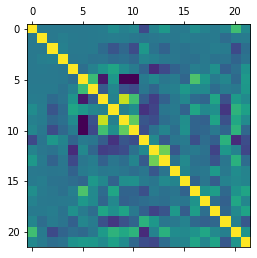

In [ ]:
# import matplotlib.pyplot as plt
# plt.matshow(final_df_drop_nan.corr())
# plt.show()

In [ ]:
import pandas as pd
import numpy as np

rs = np.random.RandomState(0)
corr = final_df_drop_nan.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,Hour,Day,Day of week,Public_holidays,Month,Year,Biomass - Actual Aggregated [MW],Fossil Brown coal/Lignite - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Hydro Pumped Storage - Actual Consumption [MW],Hydro Run-of-river and poundage - Actual Aggregated [MW],Hydro Water Reservoir - Actual Aggregated [MW],Nuclear - Actual Aggregated [MW],Other - Actual Aggregated [MW],Other renewable - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW],Actual Total Load [MW] - Spain (ES),cost
Hour,1.00,0.00,-0.00,-0.00,-0.00,0.00,0.01,0.03,0.14,0.05,0.10,-0.30,0.07,0.22,-0.00,0.01,0.15,0.07,0.01,0.08,0.49,0.11
Day,0.00,1.00,-0.00,0.04,0.01,-0.00,0.02,0.02,0.04,0.03,-0.00,-0.02,-0.01,0.01,-0.01,0.04,0.02,0.00,0.01,-0.08,0.01,0.02
Day of week,-0.00,-0.00,1.00,0.06,0.00,0.00,0.01,-0.09,-0.23,-0.11,-0.29,0.21,-0.04,-0.14,-0.02,-0.04,-0.01,-0.00,0.03,0.02,-0.30,-0.07
Public_holidays,-0.00,0.04,0.06,1.00,-0.01,-0.00,-0.04,-0.03,-0.09,-0.06,-0.11,0.08,0.05,-0.01,-0.01,-0.05,-0.05,-0.00,-0.04,-0.03,-0.14,-0.04
Month,-0.00,0.01,0.00,-0.01,1.00,-0.06,0.06,0.19,0.31,0.13,0.02,-0.13,-0.47,-0.30,-0.15,-0.08,0.04,0.01,0.17,-0.16,-0.06,0.18
Year,0.00,-0.00,0.00,-0.00,-0.06,1.00,0.47,-0.57,0.21,-0.68,-0.67,0.01,0.10,-0.01,0.02,-0.13,0.53,0.22,0.02,0.10,-0.10,0.23
Biomass - Actual Aggregated [MW],0.01,0.02,0.01,-0.04,0.06,0.47,1.00,-0.19,0.09,-0.25,-0.31,-0.02,-0.12,0.04,0.05,0.22,0.12,0.12,-0.08,0.02,-0.00,0.21
Fossil Brown coal/Lignite - Actual Aggregated [MW],0.03,0.02,-0.09,-0.03,0.19,-0.57,-0.19,1.00,0.07,0.86,0.49,-0.18,-0.37,-0.16,-0.01,0.10,-0.09,-0.13,0.31,-0.26,0.24,0.12
Fossil Gas - Actual Aggregated [MW],0.14,0.04,-0.23,-0.09,0.31,0.21,0.09,0.07,1.00,0.05,0.15,-0.43,-0.33,-0.02,0.01,-0.14,0.31,0.11,0.16,-0.40,0.41,0.27
Fossil Hard coal - Actual Aggregated [MW],0.05,0.03,-0.11,-0.06,0.13,-0.68,-0.25,0.86,0.05,1.00,0.60,-0.22,-0.28,-0.07,-0.02,0.15,-0.14,-0.15,0.30,-0.26,0.33,0.13


In [ ]:
correlations = final_df_drop_nan.corr(method='pearson')
print(correlations['cost'].sort_values(ascending=False).to_string())

cost                                                         1.000000
Other renewable  - Actual Aggregated [MW]                    0.304011
Waste  - Actual Aggregated [MW]                              0.293820
Fossil Gas  - Actual Aggregated [MW]                         0.273643
Year                                                         0.225529
Biomass  - Actual Aggregated [MW]                            0.209990
Actual Total Load [MW] - Spain (ES)                          0.188956
Month                                                        0.180023
Fossil Hard coal  - Actual Aggregated [MW]                   0.134367
Fossil Brown coal/Lignite  - Actual Aggregated [MW]          0.123686
Hour                                                         0.109652
Solar  - Actual Aggregated [MW]                              0.093243
Other  - Actual Aggregated [MW]                              0.078579
Nuclear  - Actual Aggregated [MW]                            0.073165
Day                 

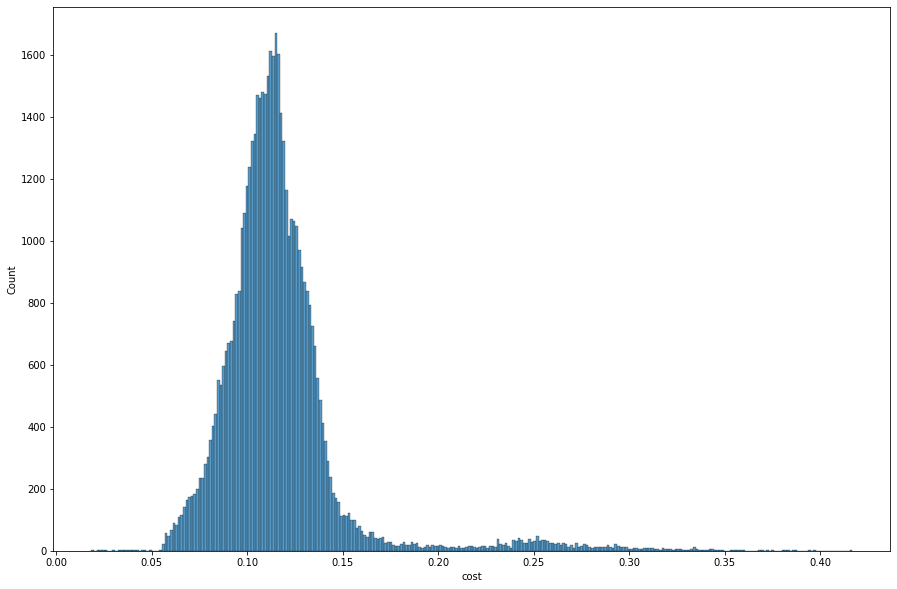

In [ ]:
# Figure Size
plt.figure(figsize=(15,10))

# Hist graph to show distribution of target variable
sns.histplot(final_df_drop_nan,x='cost');

# Electricity Price Forecasting

In [ ]:
# Model Creation
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV
from sklearn.metrics import roc_curve, plot_roc_curve, mean_absolute_error, mean_squared_error, accuracy_score

# Warnings Ignore
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Create Target variable
target='cost'

# Split data into feature matrix and target vector
y,X=final_df_drop_nan[target],final_df_drop_nan.drop(columns=target)

# split data into train / validation sets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.14265603003,random_state=42)

In [ ]:
len(y_val)

7296

#Baselines

In [ ]:
# Assign variables for baselines and calculate baselines
y_pred = [y_train.mean()]*len(y_train)
mean_baseline_pred = y_train.mean()
baseline_mae = mean_absolute_error(y_train,y_pred)
baseline_rmse = mean_squared_error(y_train,y_pred,squared=False)

# Print statement to show all baseline values
print('Mean Price Per KW/h Baseline Pred:', mean_baseline_pred)
print('-------------------------------------------------------------------')
print('Baseline Mae:',baseline_mae)
print('-------------------------------------------------------------------')
print('Baseline RMSE:',baseline_rmse)

Mean Price Per KW/h Baseline Pred: 0.11646302723148101
-------------------------------------------------------------------
Baseline Mae: 0.01979913787636025
-------------------------------------------------------------------
Baseline RMSE: 0.03315419251546757


In [ ]:
y_train

2111     0.084646
19408    0.103689
48830    0.159374
43720    0.096254
12994    0.109353
           ...   
11284    0.110857
44732    0.114602
38158    0.083650
860      0.110370
15795    0.112580
Name: cost, Length: 43848, dtype: float64

# LinearRegression

In [ ]:

# Simple imputer to fill nan values, then transform sets
simp = SimpleImputer(strategy='mean')
simp_fit = simp.fit(X_train)
XT_train = simp.transform(X_train)
XT_val = simp.transform(X_val)

# Assigning model variables
model_lr=LinearRegression()
model_r=Ridge()

# Fitting models
model_r.fit(XT_train,y_train);
model_lr.fit(XT_train,y_train);

#RandomForestRegressor & XGBRegressor

In [ ]:

# Simple imputer to fill nan values, then transform sets
simp = SimpleImputer(strategy='mean')
simp_fit = simp.fit(X_train)
XT_train = simp.transform(X_train)
XT_val = simp.transform(X_val)

# Assigning model variables
model_rfr = RandomForestRegressor()
model_xgbr=XGBRegressor()

# Fitting models
model_rfr.fit(XT_train,y_train);
model_xgbr.fit(XT_train,y_train);



[10:41:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Results Comparison

In [ ]:
# Def to check model metrics of baseline performance
def check_metrics(model):
    print(model)
    print('===================================================================')
    print('Training MAE:', mean_absolute_error(y_train,model.predict(XT_train)))
    print('-------------------------------------------------------------------')
    print('Validation MAE:', mean_absolute_error(y_val,model.predict(XT_val)))
    print('-------------------------------------------------------------------')
    print('Validation R2 score:', model.score(XT_val,y_val))
    print('===================================================================')
model = [model_r,model_lr, model_xgbr,model_rfr]
for m in model:
  check_metrics(m)

Ridge()
Training MAE: 0.01673511481754471
-------------------------------------------------------------------
Validation MAE: 0.017033324381223704
-------------------------------------------------------------------
Validation R2 score: 0.36290599074959784
LinearRegression()
Training MAE: 0.016735121362782154
-------------------------------------------------------------------
Validation MAE: 0.017033339930038607
-------------------------------------------------------------------
Validation R2 score: 0.3629058423180228
XGBRegressor()
Training MAE: 0.007261637784338306
-------------------------------------------------------------------
Validation MAE: 0.0075790820674301465
-------------------------------------------------------------------
Validation R2 score: 0.8620758721344548
RandomForestRegressor()
Training MAE: 0.0011953193396911574
-------------------------------------------------------------------
Validation MAE: 0.003190107302238279
------------------------------------------------

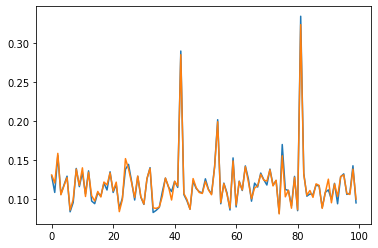

In [ ]:
plt.plot(y_val.to_numpy()[0:100])
# plt.plot(model_lr.predict(XT_val)[0:10])
# plt.plot(model_xgbr.predict(XT_val)[0:10])
plt.plot(model_rfr.predict(XT_val)[0:100])
plt.show()

## Forecast Download

In [ ]:
df_price_forecast = pd.DataFrame(data=model_rfr.predict(XT_val),  columns=['price_forecast'])
print(df_price_forecast)

      price_forecast
0           0.130820
1           0.120545
2           0.158531
3           0.105425
4           0.116820
...              ...
7291        0.133313
7292        0.095710
7293        0.133970
7294        0.095397
7295        0.109897

[7296 rows x 1 columns]


In [ ]:
df_price_forecast['y_val']= y_val.to_numpy()

In [ ]:
from google.colab import files
df_price_forecast.to_csv('price_validation_forecast.csv') 
files.download('price_validation_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusion